<h1>Part1</h1>

In [1]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz

--2025-03-14 04:50:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.13, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   319MB/s    in 4.1s    

2025-03-14 04:51:03 (309 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-15 15:29:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-15 15:29:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-15 15:29:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [1]:
def tokenize_with_offsets(sentence):
    """
    Tokenizes the sentence using split() and computes the character offsets.
    """
    tokens = sentence.split()
    offsets = []
    current_index = 0
    for token in tokens:
        # Locate the token starting from current_index
        start = sentence.find(token, current_index)
        end = start + len(token)
        offsets.append((start, end))
        current_index = end
    return tokens, offsets
def bio_encode(sentence, aspects):
    """
    Given a sentence and aspect annotations (with 'from' and 'to' indices), 
    assign token-level BIO tags and extract the aspect term texts.
    """
    tokens, offsets = tokenize_with_offsets(sentence)
    # print(tokens)
    # print(offsets)
    labels = ["O"] * len(tokens)
    aspect_terms = []
    
    for aspect in aspects:
        aspect_start = int(aspect['from'])
        aspect_end = int(aspect['to'])
        indices = []
        # Determine tokens overlapping with the aspect span
        for i, (start, end) in enumerate(offsets):
            if end > aspect_start and start < aspect_end:
                indices.append(i)
        if indices:
            labels[indices[0]] = "B"
            for j in indices[1:]:
                labels[j] = "I"
            aspect_terms.append(aspect['term'])
    
    return tokens, labels, aspect_terms

In [2]:
import json
import nltk
# nltk.download('punkt_tab')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def preprocess(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    processed_data = []
    
    for entry in data:
        sentence = entry['sentence']
        aspect_terms = entry['aspect_terms']
        tokens, labels, aspect_terms = bio_encode(sentence, aspect_terms)
        
        processed_data.append({
            'sentence': sentence,
            'tokens': tokens,
            'labels': labels,
            'aspect_terms': aspect_terms
        })
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(processed_data, f, indent=4, ensure_ascii=False)

def create_embedding_matrix(word_index, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return torch.tensor(embedding_matrix, dtype=torch.float32)

class AspectDataset(Dataset):
    def __init__(self, data, word_index, max_len):
        self.data = data
        self.word_index = word_index
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.data[idx]['tokens']
        labels = self.data[idx]['labels']
        orig_len = len(tokens)
        
        # Convert tokens to indices (lowercase for matching)
        input_ids = [self.word_index.get(token.lower(), 0) for token in tokens]
        # Map labels: 'B' -> 1, 'I' -> 2, 'O' -> 0
        label_ids = [1 if lbl == 'B' else 2 if lbl == 'I' else 0 for lbl in labels]
        
        # Truncate if longer than max_len
        input_ids = input_ids[:self.max_len]
        label_ids = label_ids[:self.max_len]
        
        # Pad if shorter than max_len
        if len(input_ids) < self.max_len:
            pad_length = self.max_len - len(input_ids)
            input_ids.extend([0] * pad_length)
            label_ids.extend([0] * pad_length)
        
        # Return original length as well
        return torch.tensor(input_ids), torch.tensor(label_ids), orig_len


def load_embeddings(embedding_path, embedding_dim):
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, num_layers=2, dropout=0.3):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, num_layers=2, dropout=0.3):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x

Using device: cuda


In [3]:
preprocess('/kaggle/input/nlp-ass2/train.json', 'train_task_1.json')
preprocess('/kaggle/input/nlp-ass2/val.json', 'val_task_1.json')

glove = load_embeddings('glove.6B.100d.txt', 100)
fasttext_model = load_embeddings('cc.en.300.vec', 300)

word_index = {word: idx for idx, word in enumerate(glove.keys())}
embedding_matrix_glove = torch.tensor(np.array(list(glove.values())), dtype=torch.float32).to(device)

word_index_fasttext = {word: idx for idx, word in enumerate(fasttext_model.keys())}
embedding_matrix_fasttext = torch.tensor(np.array(list(fasttext_model.values())), dtype=torch.float32).to(device)
print("done")

with open('/kaggle/working/train_task_1.json', 'r') as f:
    train_data = json.load(f)
with open('/kaggle/working/val_task_1.json', 'r') as f:
    val_data = json.load(f)

max_len = max(len(entry['tokens']) for entry in train_data)
train_dataset = AspectDataset(train_data, word_index, max_len)
val_dataset = AspectDataset(val_data, word_index, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


Training GRU_GloVe...
Epoch 1, Train Loss: 0.1327, Val Loss: 0.0589
Epoch 2, Train Loss: 0.0483, Val Loss: 0.0410
Epoch 3, Train Loss: 0.0294, Val Loss: 0.0382
Epoch 4, Train Loss: 0.0233, Val Loss: 0.0435
Epoch 5, Train Loss: 0.0200, Val Loss: 0.0434
Epoch 6, Train Loss: 0.0169, Val Loss: 0.0435
Epoch 7, Train Loss: 0.0147, Val Loss: 0.0454
Epoch 8, Train Loss: 0.0129, Val Loss: 0.0491
Epoch 9, Train Loss: 0.0118, Val Loss: 0.0513
Epoch 10, Train Loss: 0.0105, Val Loss: 0.0525


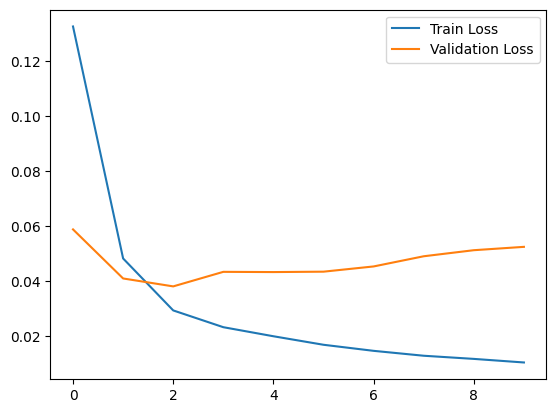

Training GRU_fastText...
Epoch 1, Train Loss: 0.1716, Val Loss: 0.0608
Epoch 2, Train Loss: 0.0416, Val Loss: 0.0436
Epoch 3, Train Loss: 0.0259, Val Loss: 0.0443
Epoch 4, Train Loss: 0.0200, Val Loss: 0.0445
Epoch 5, Train Loss: 0.0165, Val Loss: 0.0475
Epoch 6, Train Loss: 0.0144, Val Loss: 0.0493
Epoch 7, Train Loss: 0.0126, Val Loss: 0.0522
Epoch 8, Train Loss: 0.0109, Val Loss: 0.0546
Epoch 9, Train Loss: 0.0096, Val Loss: 0.0572
Epoch 10, Train Loss: 0.0089, Val Loss: 0.0638


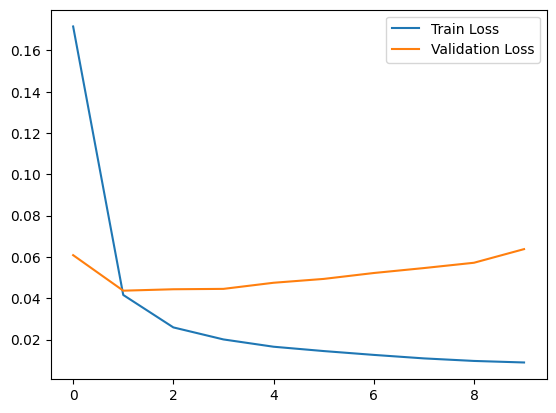

In [17]:
def train_model(model, train_loader, val_loader, epochs, learning_rate):
    model.to(device)  # Move model to GPU if available
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels, orig_len in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.show()

models = {
    "RNN_GloVe": RNNModel(len(word_index), 100, 128, 3, embedding_matrix_glove),
    "RNN_fastText": RNNModel(len(word_index), 300, 128, 3, embedding_matrix_fasttext),
    "GRU_GloVe": GRUModel(len(word_index), 100, 128, 3, embedding_matrix_glove),
    "GRU_fastText": GRUModel(len(word_index), 300, 128, 3, embedding_matrix_fasttext)
}

torch.cuda.empty_cache()
for name, model in models.items():
    print(f"Training {name}...")
    train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001)
    torch.save(model.state_dict(), f"{name}.pth")

In [8]:
a, b, c = bio_encode("All the money went into the interior decoration, none of it went to the chefs.",[
    {
      "term": "interior decoration",
      "polarity": "positive",
      "from": 28,
      "to": 47
    },
    {
      "term": "chefs",
      "polarity": "negative",
      "from": 72,
      "to": 77
    }
  ])

In [9]:
b

['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'B']

<h1>Copied Code from conlleval.py</h1>

In [10]:
"""
This script applies to IOB2 or IOBES tagging scheme.
If you are using a different scheme, please convert to IOB2 or IOBES.

IOB2:
- B = begin, 
- I = inside but not the first, 
- O = outside

e.g. 
John   lives in New   York  City  .
B-PER  O     O  B-LOC I-LOC I-LOC O

IOBES:
- B = begin, 
- E = end, 
- S = singleton, 
- I = inside but not the first or the last, 
- O = outside

e.g.
John   lives in New   York  City  .
S-PER  O     O  B-LOC I-LOC E-LOC O

prefix: IOBES
chunk_type: PER, LOC, etc.
"""
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split('-', maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True

    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tags
    pred_seqs: a list of predicted tags

    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type

    correct_counts, true_counts, pred_counts: similar to above, but for tags
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    """
    if verbose, print overall performance, as well as preformance per chunk type;
    otherwise, simply return overall prec, rec, f1 scores
    """
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i tokens with %i phrases; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i phrases; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
        
    print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
    print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
    print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))

    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])

    return res

def evaluate(true_seqs, pred_seqs, verbose=True):
    (correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
    result = get_result(correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts, verbose=verbose)
    return result

def evaluate_conll_file(fileIterator):
    true_seqs, pred_seqs = [], []
    
    for line in fileIterator:
        cols = line.strip().split()
        # each non-empty line must contain >= 3 columns
        if not cols:
            true_seqs.append('O')
            pred_seqs.append('O')
        elif len(cols) < 3:
            raise IOError("conlleval: too few columns in line %s\n" % line)
        else:
            # extract tags from last 2 columns
            true_seqs.append(cols[-2])
            pred_seqs.append(cols[-1])
    return evaluate(true_seqs, pred_seqs)

In [ ]:
preprocess('/kaggle/input/nlp-ass2/test.json', 'test_task_1.json')

glove = load_embeddings('glove.6B.100d.txt', 100)

word_index = {word: idx for idx, word in enumerate(glove.keys())}
embedding_matrix_glove = torch.tensor(np.array(list(glove.values())), dtype=torch.float32).to(device)

with open('/kaggle/working/test_task_1.json', 'r') as f:
    test_data = json.load(f)

max_len = max(len(entry['tokens']) for entry in train_data)
test_dataset = AspectDataset(test_data, word_index, max_len)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [12]:
label_map = {0: "O", 1: "B", 2: "I"}

def convert_tag(tag):
    # If tag is not O and doesn't include a hyphen, append a default chunk type
    if tag != "O" and "-" not in tag:
        return tag + "-X"
    return tag

def get_true_pred_tags(model, data_loader, label_map):
    """
    Generate lists of true and predicted tag sequences (in IOB2/IOBES format)
    for evaluation, ignoring padded tokens.
    """
    model.eval()
    true_seqs = []
    pred_seqs = []
    
    with torch.no_grad():
        for inputs, labels, lengths in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)             # shape: (batch, seq_len, num_classes)
            preds = torch.argmax(outputs, dim=2)  # shape: (batch, seq_len)
            
            # Bring tensors to CPU and convert to numpy arrays
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            # lengths is already a tensor or list of ints
            if isinstance(lengths, torch.Tensor):
                lengths = lengths.cpu().numpy()
            
            # For each sequence, only consider tokens up to the original length
            for true_labels, pred_labels, length in zip(labels, preds, lengths):
                true_seq = [convert_tag(label_map[label]) for label in true_labels[:length]]
                pred_seq = [convert_tag(label_map[label]) for label in pred_labels[:length]]
                true_seqs.append(true_seq)
                pred_seqs.append(pred_seq)
    
    return true_seqs, pred_seqs

In [13]:
def load_model(model_path):
    # Ensure the embedding matrix is on the same device as the model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [18]:
models = {
#     "RNN_GloVe.pth": RNNModel(len(word_index), 100, 128, 3, embedding_matrix_glove),
#     "RNN_fastText.pth": RNNModel(len(word_index), 300, 128, 3, embedding_matrix_fasttext),
    "GRU_GloVe.pth": GRUModel(len(word_index), 100, 128, 3, embedding_matrix_glove),
#     "GRU_fastText.pth": GRUModel(len(word_index), 300, 128, 3, embedding_matrix_fasttext)
}
for model_path, model in models.items():
        
        model = load_model("/kaggle/input/gru/pytorch/default/1/GRU_GloVe (1).pth")
        print(f"Evaluating {model_path}...")
        # Get the true and predicted tag sequences (each is a list of lists)
        true_seqs, pred_seqs = get_true_pred_tags(model, val_loader, label_map)
        
        # Flatten the lists so that each token tag becomes an element in a single list.
        flat_true_seqs = [tag for seq in true_seqs for tag in seq]
        flat_pred_seqs = [tag for seq in pred_seqs for tag in seq]
        len(flat_true_seqs)
        
        # Now pass the flattened lists to the evaluation function
        evaluate(flat_true_seqs, flat_pred_seqs)
            # print(f"Final Evaluation - {name}: Chunk F1: {chunk_f1:.4f}, Tag F1: {tag_f1:.4f}")

<ipython-input-13-e4477553aeb0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating GRU_GloVe.pth...
processed 4284 tokens with 371 phrases; found: 377 phrases; correct: 241.
accuracy:  69.50%; (non-O)
accuracy:  93.46%; precision:  63.93%; recall:  64.96%; FB1:  64.44
                X: precision:  63.93%; recall:  64.96%; FB1:  64.44  377
Evaluating GRU_fastText.pth...
processed 4284 tokens with 371 phrases; found: 361 phrases; correct: 228.
accuracy:  64.11%; (non-O)
accuracy:  93.07%; precision:  63.16%; recall:  61.46%; FB1:  62.30
                X: precision:  63.16%; recall:  61.46%; FB1:  62.30  361
